## Description of the project:

   In this part of the class, we will curate a set of **CO2 measurements**, measured from cheap but inaccurate sensors, that have been deployed in the city of Zurich. The goal of the exercise is twofold: 

1. Learn how to deal with real world sensor timeseries data, and organize them efficiently using python dataframes.

2. Apply data science tools to model the measurements, and use the learned model to process them (e.g., detect outliers and drifts in the sensor measurements). 

The sensor network consists of 46 sites, located in different parts of the city. Each site contains three different sensors measuring (a) **CO2 concentration**, (b) **temperature**, and (c) **humidity**. Beside these measurements, we have the following additional information that can be used to process the measurements: 


1. The average **daily wind pattern** for the city of Zurich 

2. The **altitude** at which the CO2 sensor is located

3. A clustering of the city of Zurich in 17 different zones and the **city zone** in which the sensor belongs to. Some characteristic zones are industrial area, residential area, forest, glacier, lake, etc.

Given this knowledge, you are asked to define a machine learning algorithm that curates the data, by detecting potential outliers or drifts. The algorithm should be based on the fact that sensors in similar conditions are expected to have similar measurements.

## Prior knowledge:
    
The average value of the CO2 in a city is approximately 400 ppm. However, the exact measurement in each site depends on parameters such as the temperature, the humidity, the wind, the altitude, and the level of traffic around the site. For example, sensors positioned in high altitude (mountains) and exposed to stronger winds, are expected to have a much lower and uniform level of CO2 than sensors that are positioned in a business area with much higher traffic activity. Moreover, we know that there is a strong dependence of the CO2 measurements, on temperature and humidity.



## Goal:
    
  We would like to use the above knowledge in order to fit a robust regression model to the CO2 measurements. This model should be built by processing the measurements of the entire sensor network jointly, and it should take into account the dependence on the above mentioned parameters. Finally, the learned model will be used to curate the CO2 measurements by detecting possible outliers and drifts. 

**Note:**
Different machine learning approaches can be used to solve the problem. For simplicity, we provide a suggested approach, and the corresponding steps that can guide your solution. 


### Imports

Import the following python packages: pandas, datetime, matplotlib, numpy, sklearn

In [1]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import sklearn
import array

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

### To start with: 

The following csv files will be needed: 

- `CO2_sensor_measurements.csv`

Description: It containts the CO2 measurements (CO2), the name of the site (LocationName), a unique sensor identifier (SensorUnit_ID), and the time instance in which the measurement was taken (timestamp).
    
- `temperature_humidity.csv`

Description: It contains the temperature and the humidity measurements for each sensor identifier, at each timestamp (Timestamp). For each SensorUnit_ID, the temperature and the humidity can be found in the corresponding columns of the dataframe (SensorUnit_ID.temperature, SensorUnit_ID.humidity).
    
- `sensor_metadata.csv`

Description: It contains the name of the site (LocationName), the zone index (zone), and the altitude in meters. 
    
- `zurich_average_wind.csv`

Description: It contains the average wind speed (wind_speed) in the city of Zurich measured every 30 minutes (timestamp).

In [2]:
CO2_measurement = pd.read_csv('CO2_sensor_measurements.csv', sep='\t')
zurich_average_wind = pd.read_csv('zurich_average_wind.csv', sep='\t')
zurich_temp_humidity= pd.read_csv('temperature_humidity.csv', sep='\t')
sensors_metadata = pd.read_csv('sensors_metadata.csv', sep='\t') 




## PART I: Handling time series with pandas (15 points)

### Question I.a. (12/15)

Organize the CO2_sensor_measurements.csv and temperature_humidity.csv files into a single dataframe that contains as index the time instance (timestamp) of the measurements, and columns the location of the site (LocationName), the sensor ID (SensorUnit_ID), the CO2 measurement, the temperature, and the humidity. For each measurement (CO2, humidity, temperature), take the average over an interval of 30 min. If there are missing measurements, interpolate them linearly from measurements that are close by in time.

Hints: the following methods could be useful:

- [pandas.DataFrame.resample()](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.resample.html)
    
- [pandas.DataFrame.interpolate()](https://pandas.pydata.org/pandasdocs/stable/generated/pandas.DataFrame.interpolate.html)

- [pandas.DataFrame.mean()](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.mean.html)

- [pandas.DataFrame.append()](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.append.html)

First of all, we make sure each sensor is assocaited to a single location.  

In [3]:
print( "There are %s sensors." % len( pd.unique(CO2_measurement["SensorUnit_ID"]) ) )
print( "There are %s locations.\n" % len( pd.unique(CO2_measurement["LocationName"]) ) )

sensors_location = pd.DataFrame()
sensors_location = CO2_measurement[["SensorUnit_ID", "LocationName"]].drop_duplicates().groupby("LocationName").count()
sensors_location.rename(columns={ 'SensorUnit_ID': 'SensorsCount' }, inplace=True)


print( "There are %s unique pairs Location/Sensor, each location having only 1 sensor : %s" % 
      (sensors_location.shape[0], sensors_location[ sensors_location.SensorsCount != 1 ].empty ) ) 

There are 46 sensors.
There are 46 locations.

There are 46 unique pairs Location/Sensor, each location having only 1 sensor : True


#### Resample CO2 measurement

In [4]:
CO2_measurement.head()

,timestamp,LocationName,SensorUnit_ID,CO2
0,2017-10-01 00:05:00,ZGHD,1014,593.321562
1,2017-10-01 00:15:00,ZGHD,1014,595.846258
2,2017-10-01 00:25:00,ZGHD,1014,595.845353
3,2017-10-01 00:45:00,ZGHD,1014,599.039129
4,2017-10-01 00:55:00,ZGHD,1014,594.996629


In [5]:
# Check for NaN values in the dataframe
CO2_measurement.isnull().any()

timestamp        False
LocationName     False
SensorUnit_ID    False
CO2              False
dtype: bool

In [6]:
 def resample_CO2 ( data ) :
    """
    Function to resample the CO2 measurement dataframe
    """
    resampled_df = pd.DataFrame()
    
    for sensor in set( data['SensorUnit_ID'].values ):
        
        df = data.loc[data['SensorUnit_ID'] == sensor]
        df = df.set_index(['timestamp',])
        df.index = pd.to_datetime(df.index)        
        df = df.groupby(['LocationName','SensorUnit_ID']).resample('30T').mean()
        resampled_df = resampled_df.append([df])
        
    return resampled_df

In [7]:
resampled_CO2 = resample_CO2(CO2_measurement).interpolate(method='linear').drop('SensorUnit_ID',axis=1)

In [8]:
# Convert multi-index to column
resampled_CO2 = resampled_CO2.reset_index().set_index('timestamp', drop=True)
resampled_CO2.head()

,LocationName,SensorUnit_ID,CO2
timestamp,,,
2017-10-01 00:00:00,ZSBN,1031,418.493079
2017-10-01 00:30:00,ZSBN,1031,418.169200
2017-10-01 01:00:00,ZSBN,1031,421.749522
2017-10-01 01:30:00,ZSBN,1031,424.363039
2017-10-01 02:00:00,ZSBN,1031,423.172512


In [9]:
resampled_CO2.shape

(66667, 3)

#### Resample temperature and humidity

In [10]:
zurich_temp_humidity.head()

,Timestamp,1014.temperature,1014.humidity,1015.temperature,1015.humidity,1016.temperature,1016.humidity,1017.temperature,1017.humidity,1018.temperature,...,1291.temperature,1291.humidity,1292.temperature,1292.humidity,1297.temperature,1297.humidity,1298.temperature,1298.humidity,1299.temperature,1299.humidity
0,2017-10-01 00:00:00,11.39,92.262787,10.55,91.949982,11.02,92.613739,11.05,89.811844,11.38,...,10.13,96.828979,10.50,95.858139,10.70,94.524902,11.35,90.288681,11.44,90.118927
1,2017-10-01 00:10:00,11.39,92.579407,10.48,92.079681,11.04,93.063873,11.05,90.042633,11.38,...,10.12,97.322983,10.45,95.903915,10.53,94.395203,11.35,90.422195,11.46,90.073151
2,2017-10-01 00:20:00,11.41,92.480225,10.51,92.583221,11.06,93.201202,11.02,89.888138,11.35,...,10.14,97.780746,10.43,95.343155,10.45,94.620270,11.33,91.023010,11.41,89.466614
3,2017-10-01 00:30:00,11.35,91.902298,10.55,92.714828,11.02,92.932266,10.96,89.790863,11.31,...,10.13,97.904724,10.43,95.322174,10.42,94.973129,11.32,91.019196,11.39,89.249176
4,2017-10-01 00:40:00,11.30,91.639084,10.59,92.764420,10.99,92.598480,10.95,89.821381,11.27,...,10.13,97.931427,10.48,96.451324,10.46,95.282120,11.28,90.443176,11.31,88.871521


In [11]:
def resample_temp_humidity(data):
    """
    Function to resample the dataframe containing humidity and temperature
    """
    data = data.set_index('Timestamp')
    data.index = pd.to_datetime(data.index)
    
    new_data=pd.DataFrame(index = data.index)
    #new_data['LocationName']  = pd.Series()
    new_data['SensorUnit_ID'] = pd.Series()
    new_data['temperature']   = pd.Series()
    new_data['humidity']      = pd.Series()

    temp = new_data
    empty = temp
    new_data = pd.DataFrame()

    for i in data.columns :
        
        [ID,col] = i.split('.')
        temp[col] = data[i]
        #Here we assume that pair of columns are always ordered as [id_1.temp, id_1.hum, id_2.temp, id_2.hum ....]
        if col == 'humidity':# ie, if we are treating the second column for this particular sensorID
            temp['SensorUnit_ID']  = int(ID)
            temp=temp.groupby('SensorUnit_ID').resample('30T').mean()
            new_data = new_data.append(temp)
            temp = empty
    
    
    return new_data

In [12]:
resampled_temp_humidity = resample_temp_humidity(zurich_temp_humidity).interpolate(method='linear').drop('SensorUnit_ID', axis=1)
resampled_temp_humidity = resampled_temp_humidity.reset_index().set_index('Timestamp', drop=True)
resampled_temp_humidity.head()

,SensorUnit_ID,temperature,humidity
Timestamp,,,
2017-10-01 00:00:00,1014,11.396667,92.440806
2017-10-01 00:30:00,1014,11.325000,91.770691
2017-10-01 01:00:00,1014,11.240000,91.096761
2017-10-01 01:30:00,1014,11.260000,91.275734
2017-10-01 02:00:00,1014,11.290000,91.061157


In [13]:
resampled_temp_humidity.shape

(68448, 3)

#### Merge the 2 dataframes

Before merging the 2 resampled dataframe, we make sure that each sensor is present in the 2 dataframe. That none is present in one dataframe but not in the other.

Then, we notice that our dataframes have different shape because the measurements from sensor ***ZPFW 1174*** start on 2017-10-19 at 13:00:00 and measurements from sensor ***ZHRO 1117*** start on 2017-10-19 at 13:30:00. Before that time we have no CO2 measurements for ZPFW and ZHRO.

Knowing this, we are still doing an outer join in order not to lose the information on the temperature and humidity performed before that date.

In [14]:
resampled_CO2[resampled_CO2.SensorUnit_ID == 1174 ].head()

,LocationName,SensorUnit_ID,CO2
timestamp,,,
2017-10-19 13:00:00,ZPFW,1174,424.071578
2017-10-19 13:30:00,ZPFW,1174,419.365710
2017-10-19 14:00:00,ZPFW,1174,413.355557
2017-10-19 14:30:00,ZPFW,1174,415.245809
2017-10-19 15:00:00,ZPFW,1174,415.895096


In [15]:
resampled_CO2[resampled_CO2.SensorUnit_ID == 1117 ].head()

,LocationName,SensorUnit_ID,CO2
timestamp,,,
2017-10-19 13:30:00,ZHRO,1117,433.718986
2017-10-19 14:00:00,ZHRO,1117,430.520888
2017-10-19 14:30:00,ZHRO,1117,425.265832
2017-10-19 15:00:00,ZHRO,1117,432.520878
2017-10-19 15:30:00,ZHRO,1117,435.753967


In [16]:
print( "No sensors are present in resampled_temp_humidity but not in resampled_CO2 : ",  
      resampled_temp_humidity[~resampled_temp_humidity.SensorUnit_ID.isin(resampled_CO2.SensorUnit_ID)].empty )

No sensors are present in resampled_temp_humidity but not in resampled_CO2 :  True


In [17]:
print( "No sensors are present in resampled_CO2 but not in resampled_temp_humidity : ",  
      resampled_CO2[~resampled_CO2.SensorUnit_ID.isin(resampled_temp_humidity.SensorUnit_ID)].empty )

No sensors are present in resampled_CO2 but not in resampled_temp_humidity :  True


In [18]:
resampled_CO2['timestamp'] = resampled_CO2.index
resampled_temp_humidity['timestamp'] = resampled_temp_humidity.index

resampled_meas = pd.merge( resampled_CO2, resampled_temp_humidity, on=['timestamp','SensorUnit_ID'], how="outer" )
resampled_meas = resampled_meas.set_index('timestamp', drop=True)
resampled_meas.tail()

,LocationName,SensorUnit_ID,CO2,temperature,humidity
timestamp,,,,,
2017-10-19 10:30:00,NaN,1174,NaN,14.856667,67.263804
2017-10-19 11:00:00,NaN,1174,NaN,15.863333,65.317673
2017-10-19 11:30:00,NaN,1174,NaN,20.733333,57.518524
2017-10-19 12:00:00,NaN,1174,NaN,22.943333,50.104660
2017-10-19 12:30:00,NaN,1174,NaN,23.916667,43.019496


In [19]:
resampled_meas.isnull().any()

LocationName      True
SensorUnit_ID    False
CO2               True
temperature      False
humidity         False
dtype: bool

In [20]:
print( "As expected, we are missing CO2 measurements in the merged dataframe for sensors ID in", 
      resampled_meas[ resampled_meas.CO2.isnull() ].SensorUnit_ID.unique() )

As expected, we are missing CO2 measurements in the merged dataframe for sensors ID in [1117 1174]


Since `LocationName` is needed in order to get the metadata of the sensors later one. We retrieve the missing data. 

In [21]:
# Add missing LocationName
resampled_meas.loc[resampled_meas.SensorUnit_ID == 1174, 'LocationName'] = 'ZPFW'
resampled_meas.loc[resampled_meas.SensorUnit_ID == 1117, 'LocationName'] = 'ZHRO'
resampled_meas.tail()

,LocationName,SensorUnit_ID,CO2,temperature,humidity
timestamp,,,,,
2017-10-19 10:30:00,ZPFW,1174,NaN,14.856667,67.263804
2017-10-19 11:00:00,ZPFW,1174,NaN,15.863333,65.317673
2017-10-19 11:30:00,ZPFW,1174,NaN,20.733333,57.518524
2017-10-19 12:00:00,ZPFW,1174,NaN,22.943333,50.104660
2017-10-19 12:30:00,ZPFW,1174,NaN,23.916667,43.019496


In [22]:
resampled_meas.isnull().any()

LocationName     False
SensorUnit_ID    False
CO2               True
temperature      False
humidity         False
dtype: bool

Hint: Your dataframe should look like that

In [23]:
pd.read_csv('Hint_Ia.csv', index_col='Unnamed: 0')

,CO2,LocationName,SensorUnit_ID,temperature,humidity
2017-10-01 00:00:00,595.004391,ZGHD,1014,11.396667,92.440806
2017-10-01 00:30:00,597.017879,ZGHD,1014,11.325000,91.770691
2017-10-01 01:00:00,596.487010,ZGHD,1014,11.240000,91.096761
2017-10-01 01:30:00,598.787639,ZGHD,1014,11.260000,91.275734
2017-10-01 02:00:00,595.366394,ZGHD,1014,11.290000,91.061157


### Question I.b. (3/15)

Export the curated and ready to use timeseries to a csv file. 

In [24]:
resampled_meas.to_csv('zurich_measurements.csv')

## PART II: Finding meaningful structures/patterns in the data (20 points)

### Question II.a. (3/30)

Plot the daily median CO2 measurement for each site with respect to the altitude. Annotate each point of the plot with the name of the location (LocationName).

#### Import the measurments from sensors in Zurich area 

In [25]:
zurich_meas = pd.read_csv("zurich_measurements.csv")
zurich_meas.head()

,timestamp,LocationName,SensorUnit_ID,CO2,temperature,humidity
0,2017-10-01 00:00:00,ZSBN,1031,418.493079,11.146667,92.608017
1,2017-10-01 00:30:00,ZSBN,1031,418.169200,10.915000,92.220825
2,2017-10-01 01:00:00,ZSBN,1031,421.749522,10.860000,92.662059
3,2017-10-01 01:30:00,ZSBN,1031,424.363039,10.820000,92.934809
4,2017-10-01 02:00:00,ZSBN,1031,423.172512,10.760000,93.407832


#### Get the metadata of the sensors 

In [26]:
metadata = sensors_metadata.set_index(['LocationName'])
altitude = metadata['altitude']
metadata.head()

,zone,altitude
LocationName,,
AJGR,2.0,627.8
BSCR,2.0,462.3
BUDF,10.0,490.2
KBRL,7.0,510.5
KTGM,2.0,530.3


#### Merge the measurements with the metadata on LocationName

In [27]:
metadata = metadata.reset_index()
zurich_meas = zurich_meas.merge( metadata, on=['LocationName'], how="outer" )
zurich_meas.head()

,timestamp,LocationName,SensorUnit_ID,CO2,temperature,humidity,zone,altitude
0,2017-10-01 00:00:00,ZSBN,1031,418.493079,11.146667,92.608017,3.0,415.4
1,2017-10-01 00:30:00,ZSBN,1031,418.169200,10.915000,92.220825,3.0,415.4
2,2017-10-01 01:00:00,ZSBN,1031,421.749522,10.860000,92.662059,3.0,415.4
3,2017-10-01 01:30:00,ZSBN,1031,424.363039,10.820000,92.934809,3.0,415.4
4,2017-10-01 02:00:00,ZSBN,1031,423.172512,10.760000,93.407832,3.0,415.4


Each row has a corresponding altitude and zone. 

In [28]:
zurich_meas.isnull().any()

timestamp        False
LocationName     False
SensorUnit_ID    False
CO2               True
temperature      False
humidity         False
zone             False
altitude         False
dtype: bool

In [29]:
# Compute the daily meadian for each sensor 
zurich_meas = zurich_meas.drop(['temperature', 'humidity','zone'], axis=1)
zurich_meas = zurich_meas.set_index('timestamp', drop=True)
zurich_meas.index = pd.to_datetime(zurich_meas.index)
zurich_meas = zurich_meas.groupby(['LocationName','SensorUnit_ID'], ).resample('D').median()
zurich_meas = zurich_meas.reset_index("LocationName")
zurich_meas = zurich_meas.dropna(axis=0, how='any')
zurich_meas.tail()

LocationName  SensorUnit_ID         CO2  altitude
SensorUnit_ID timestamp                                                   
1178          2017-10-27         ZWCH           1178  450.443069     450.0
              2017-10-28         ZWCH           1178  439.758763     450.0
              2017-10-29         ZWCH           1178  434.345359     450.0
              2017-10-30         ZWCH           1178  453.914400     450.0
              2017-10-31         ZWCH           1178  476.797222     450.0

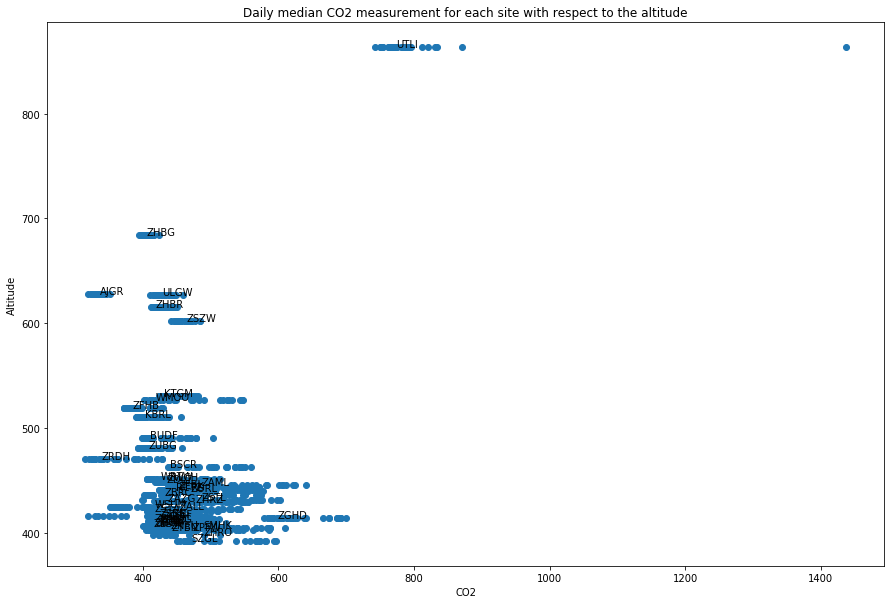

In [30]:
# Plot the daily meadian CO2 measurement for each location

location = ""

fig, ax = plt.subplots(figsize=(15, 10))
ax.scatter(zurich_meas.CO2, zurich_meas.altitude)
ax.set_title("Daily median CO2 measurement for each site with respect to the altitude")
ax.set_xlabel("CO2")
ax.set_ylabel("Altitude")

for i, row in zurich_meas.iterrows():
    current = row.LocationName
    store = row.LocationName
    if current != location:
        location = row.LocationName
        ax.text(row.CO2, row.altitude, str(row.LocationName))

plt.show()

### Question II.b. (7/20)

**Altitude clustering:** Cluster the sites based on their altitude, by performing a K-means clustering. Set the number of clusters to 4. 

In [31]:
# Convert DataFrame to matrix
from sklearn.cluster import KMeans
matrix = metadata.drop(['LocationName'], axis=1).as_matrix()

# Apply kmeans clustering
km = KMeans(n_clusters=4)
km.fit(matrix)

# Get cluster assignment labels
labels = km.labels_

In [32]:
alt_clusters = pd.Series(data = labels, index = metadata.index)

In [33]:
metadata['cluster'] = alt_clusters

In [34]:
alt_clusters = metadata.sort_values('cluster')
alt_clusters.head()

,LocationName,zone,altitude,cluster
22,ZFRK,2.0,442.0,0
23,ZGHD,2.0,413.5,0
26,ZHRG,3.0,410.5,0
27,ZHRO,2.0,397.6,0
28,ZHRZ,3.0,429.5,0


### Question II.c. (7/20)

**Temporal clustering:** Cluster the days of the month based on the average wind conditions of the city of Zurich. 

First, resample the daily wind signal by computing the mean over an interval of 30 min. 

Then, consider each day as a 48-dimensional sample (30 min intervals per day). Perform a principle component analysis of the wind values to reduce the dimension to 2.  
Hint: You can use `pandas.DataFrame.grouby()` and `for` to generate the daily sample ([documentation](https://pandas.pydata.org/pandas-docs/stable/groupby.html#iterating-through-groups)).

Finally, apply K-means to the first two PCA coefficients. Set the number of clusters to 6.

In [35]:
zurich_average_wind.head()

,timestamp,wind_speed
0,2017-10-01 00:00:00,2.330000
1,2017-10-01 00:30:00,1.480000
2,2017-10-01 01:00:00,0.950000
3,2017-10-01 01:30:00,0.923333
4,2017-10-01 02:00:00,0.776667


In [36]:
# Resample the data
wind = zurich_average_wind.set_index(['timestamp'])
wind.index = pd.to_datetime(wind.index)
wind = wind.resample('30T').mean()

In [37]:
data = wind.as_matrix().reshape((31,48))

In [38]:
# Perform PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(data)
transform_data = pca.transform(data)
PCA_data = pd.DataFrame(transform_data, index = wind.resample('D').mean().index )

In [39]:
from sklearn.cluster import KMeans

matrix = PCA_data.as_matrix()

# Apply K-mean clustering
km = KMeans(n_clusters=6)
km.fit( matrix )

# Get cluster assignment labels
labels = km.labels_
temp_clusters = pd.Series(data= labels, index = PCA_data.index)
PCA_data['cluster'] = temp_clusters
temp_clusters = PCA_data.sort_values('cluster')
temp_clusters.head(10)

,0,1,cluster
timestamp,,,
2017-10-31,-1.922598,-0.539616,0
2017-10-02,-0.869377,4.207631,0
2017-10-04,-3.281485,-0.074907,0
2017-10-07,-3.117599,1.896065,0
2017-10-20,-1.712431,3.719850,0
2017-10-10,-4.154495,1.617377,0
2017-10-11,-3.576478,1.514059,0
2017-10-26,-5.665380,-1.105998,1
2017-10-25,-5.158913,-0.270862,1


### Question II.d. (3/20)

Choose one of the wind clusters, and plot the average wind of the days corresponding to that cluster. 

In [40]:
# We choose cluster 5
cluster = 5

In [41]:
# Get the average wind by days and merge to the clusters dataframe 
wind = wind.resample('D').mean()
temp_clusters = pd.merge(temp_clusters, wind, right_index=True, left_index=True)


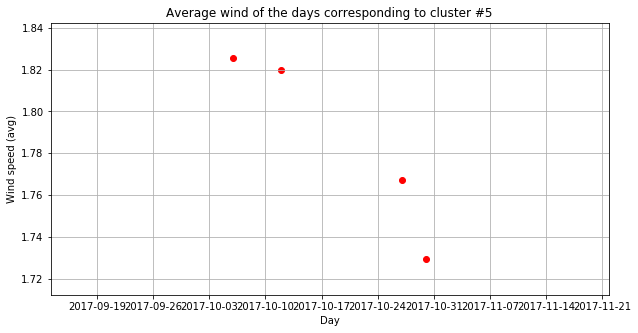

In [42]:
# Plot the average wind for cluster 5
fig, ax = plt.subplots(figsize=(10, 5))

ax.scatter( temp_clusters[temp_clusters.cluster == cluster ].index, 
            temp_clusters[temp_clusters.cluster == cluster ].wind_speed,
            color='red')

ax.set_title("Average wind of the days corresponding to cluster #%s" % cluster )
ax.set_xlabel("Day")
ax.set_ylabel("Wind speed (avg)")
ax.grid()

plt.show()

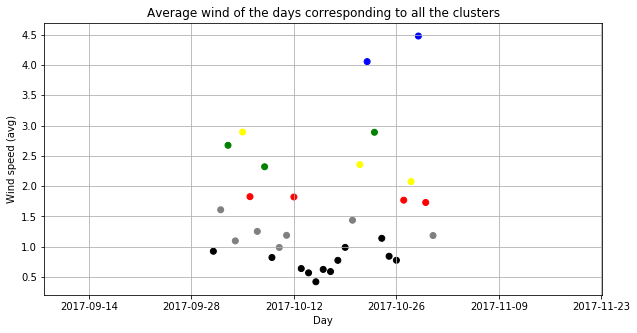

In [43]:
# Plot the average wind for all clusters

LABEL_COLOR_MAP = {0 : 'gray',
                   1 : 'black',
                   2 : 'green',
                   3 : 'blue',
                   4 : 'yellow',
                   5 : 'red'
                   }

label_color = [LABEL_COLOR_MAP[l] for l in temp_clusters.cluster]

fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(temp_clusters.index, temp_clusters.wind_speed, c=label_color)
ax.set_title("Average wind of the days corresponding to all the clusters")
ax.set_xlabel("Day")
ax.set_ylabel("Wind speed (avg)")
ax.grid()

plt.show()

## PART III: Model fitting for outlier detection (15 points)


### Question III.a.(5/15)

A domain expert indicates that there is problem with the `ZSBN` sensor, which appears after October 24. You decide to fit a linear model to the CO2 measurements of the site, by considering as features the temperature and the humidity. Plot and compare the actual CO2 measurements, and the values obtained by the prediction of the linear model for the entire month of October. Can you guess the problem from your plot?

In [44]:
# Import the data
resampled_meas = pd.read_csv("zurich_measurements.csv")
resampled_meas = resampled_meas.set_index('timestamp')
resampled_meas.index = pd.to_datetime(resampled_meas.index)

Since we decided to do an outer merge on the first part of the assignment, we have some NaN values for the CO2 measurements. We drop rows having no CO2 measurements before doing the linear regression. 

In [45]:
# Drop rows without CO2 measurements 
resampled_meas = resampled_meas.dropna(subset=["CO2"])
print( resampled_meas.isnull().any() )

LocationName     False
SensorUnit_ID    False
CO2              False
temperature      False
humidity         False
dtype: bool


In [46]:
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler


def linear_model( data ):
    """
    Function to fit a linear model to the CO2 measurements 
    considering the temperature and the humidity as features
    """

    lm = LinearRegression()
    predictors = data[["temperature","humidity"]]
    target = data.CO2
    
    X_train, X_test, y_train, y_test = train_test_split(predictors.as_matrix(), 
                                                        target.as_matrix(),
                                                        test_size=1/7, 
                                                        random_state=5)
    
    lm.fit(X_train, y_train)
        
    score = lm.score(X_test, y_test)
    
    return lm

In [47]:
# Build linear model from entire dataset
lm = linear_model(resampled_meas)
predictions_ZSBN = lm.predict(resampled_meas[resampled_meas.LocationName == 'ZSBN'][["temperature","humidity"]])

In [48]:
def plot_prediction( prediction, measurement, index ):

    fig,ax = plt.subplots(figsize=(15,5))
    fig.autofmt_xdate()

    ax.plot(index, 
            prediction)
    ax.plot( index, 
            measurement)
    ax.set_title("Comparison between the CO2 measurements of ZSBN and the prediction of the linear model for the month of October.")
    ax.set_ylabel("CO2")
    ax.legend(['Prediction', 'Measurements'])
    ax.xaxis.set_major_locator( mdates.DayLocator() )
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%D'))

    plt.show()

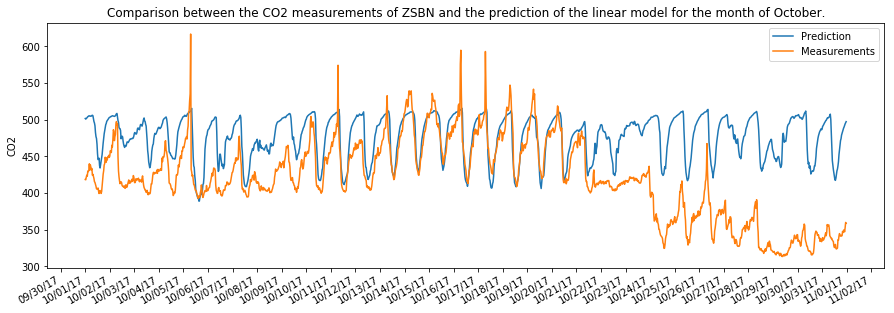

In [49]:
plot_prediction(predictions_ZSBN, resampled_meas[resampled_meas.LocationName == 'ZSBN'].CO2 , resampled_meas[resampled_meas.LocationName == 'ZSBN'].index)

Yes, we can clearly see the problem with this plot, starting from 24th of October (even thow the ticks dont show this date), we can see the difference between the prediction and the mesurement for this particular sensor grows with time after that date. Thez are no longuer superposable

### Question III.b. (8/15)

In your next attempt to find the problem, you decide to use the temporal and altitude clusters computed in PART II, together with the zone clusters of the city that are already provided, to improve your model. 

First, find the sensors belonging to the same zone and altitude cluster. Keep only the part of the dataframe from Part I.a that matches the same zone and altitude cluster with `ZSBN`.

Then, partition the obtained dataframe into six parts, each corresponding to one of the wind clusters.  

Use the partitioned dataframes to learn a new regression model for each of them. For each linear model, use as features 1) the temperature, 2) the humidity, and 3) the time of the day measured in the range between 0 and 47 (intervals of 30 min). At the end of this step, you should have obtained a simple linear regression model for each wind cluster.

Finally, plot and compare the actual CO2 measurements, and the values obtained by the linear model for the entire month of October. If all the steps are done correcly, you should be able to clearly detect the drift observed after October 26th.

In [50]:
zone = float( alt_clusters[alt_clusters.LocationName == 'ZSBN'].zone )
cluster = int( alt_clusters[alt_clusters.LocationName == 'ZSBN'].cluster )
print("The zone of ZSBN is %s, and the wind cluster is %s" % (zone, cluster))

The zone of ZSBN is 3.0, and the wind cluster is 0


In [51]:
alt_clusters_ZSBN = alt_clusters[ alt_clusters.cluster == cluster]
alt_clusters_ZSBN = alt_clusters_ZSBN[ alt_clusters_ZSBN.zone == zone]
alt_clusters_ZSBN

,LocationName,zone,altitude,cluster
26,ZHRG,3.0,410.5,0
28,ZHRZ,3.0,429.5,0
44,ZUE,3.0,408.8,0
36,ZSBN,3.0,415.4,0


See below the sensors that are in the same zone and altitude cluster than ZSBN.

In [52]:
# Keep only measurements from sensors belonging to the same zone and altitude cluster than ZSBN
sensors_location = alt_clusters_ZSBN.LocationName.tolist()

resampled_meas = pd.read_csv("zurich_measurements.csv")
resampled_meas = resampled_meas.set_index('timestamp')
resampled_meas.index = pd.to_datetime(resampled_meas.index)

ZSBN_neighbors = resampled_meas[ resampled_meas.LocationName.isin( sensors_location ) ]

In [53]:
# Compute a period number ( from 0 to 47 ) based on the time of the day
ZSBN_neighbors['date'] = pd.to_datetime( ZSBN_neighbors.index.date )
ZSBN_neighbors['period'] = ( ( ZSBN_neighbors.index.hour*60+ZSBN_neighbors.index.minute+ZSBN_neighbors.index.second/60 ) / 30 )
ZSBN_neighbors['period'] = ZSBN_neighbors['period'].astype(int)

print( "Periods spread from %s to %s " % ( ZSBN_neighbors.period.min(), ZSBN_neighbors.period.max()) )

ZSBN_neighbors.head()

Periods spread from 0 to 47 


,LocationName,SensorUnit_ID,CO2,temperature,humidity,date,period
timestamp,,,,,,,
2017-10-01 00:00:00,ZSBN,1031,418.493079,11.146667,92.608017,2017-10-01,0
2017-10-01 00:30:00,ZSBN,1031,418.169200,10.915000,92.220825,2017-10-01,1
2017-10-01 01:00:00,ZSBN,1031,421.749522,10.860000,92.662059,2017-10-01,2
2017-10-01 01:30:00,ZSBN,1031,424.363039,10.820000,92.934809,2017-10-01,3
2017-10-01 02:00:00,ZSBN,1031,423.172512,10.760000,93.407832,2017-10-01,4


In [54]:
# Merge measurements to the wind_cluster 
ZSBN_neighbors['time']=ZSBN_neighbors.index
temp_clusters['date'] = temp_clusters.index
ZSBN_neighbors = pd.merge( ZSBN_neighbors, temp_clusters, how='outer', on='date') 

In [55]:
ZSBN_neighbors= ZSBN_neighbors.set_index('time')

In [56]:
ZSBN_neighbors.isnull().any()

LocationName     False
SensorUnit_ID    False
CO2              False
temperature      False
humidity         False
date             False
period           False
0                False
1                False
cluster          False
wind_speed       False
dtype: bool

In [57]:
ZSBN_neighbors = ZSBN_neighbors.drop([0,1], axis=1)

In [58]:
# Divide the dataframe into 6 dataframes, each corresponding to a wind cluster
ZSBN_neighbors_by_cluster = {}

for i in range(0,6):
    ZSBN_neighbors_by_cluster[i] = ZSBN_neighbors[ ZSBN_neighbors.cluster == i ]

In [59]:
ZSBN_neighbors_by_cluster[0].head()

,LocationName,SensorUnit_ID,CO2,temperature,humidity,date,period,cluster,wind_speed
time,,,,,,,,,
2017-10-02 00:00:00,ZSBN,1031,450.524917,10.313333,93.402110,2017-10-02,0,0,1.608333
2017-10-02 00:30:00,ZSBN,1031,457.765648,10.346667,93.639257,2017-10-02,1,0,1.608333
2017-10-02 01:00:00,ZSBN,1031,456.454367,10.406667,93.930445,2017-10-02,2,0,1.608333
2017-10-02 01:30:00,ZSBN,1031,455.316726,10.485000,93.916458,2017-10-02,3,0,1.608333
2017-10-02 02:00:00,ZSBN,1031,465.162407,10.513333,94.168864,2017-10-02,4,0,1.608333


In [60]:
def linear_model_2( data ):
    """
    Function to fit a linear model to the CO2 measurements 
    considering the temperature, the humidity and wind as features
    """

    lm = LinearRegression()
    predictors = data[["temperature","humidity","period"]]
    target = data.CO2
        
    X_train = predictors.as_matrix()
    y_train = target.as_matrix()
    lm.fit(X_train, y_train)
        
    return lm

In [61]:
# Build linear models. One for each wind cluster
lm0 = linear_model_2(ZSBN_neighbors_by_cluster[0])
lm1 = linear_model_2(ZSBN_neighbors_by_cluster[1])
lm2 = linear_model_2(ZSBN_neighbors_by_cluster[2])
lm3 = linear_model_2(ZSBN_neighbors_by_cluster[3])
lm4 = linear_model_2(ZSBN_neighbors_by_cluster[4])
lm5 = linear_model_2(ZSBN_neighbors_by_cluster[5])

In [62]:
# Predict the CO2 level of ZSBN using the corresponding linear model

predictions_ZSBN = lm0.predict(ZSBN_neighbors_by_cluster[0][["temperature","humidity","period"]])
ZSBN_neighbors_by_cluster[0]['Prediction'] = predictions_ZSBN


predictions_ZSBN = lm1.predict(ZSBN_neighbors_by_cluster[1][["temperature","humidity","period"]])
ZSBN_neighbors_by_cluster[1]['Prediction'] = predictions_ZSBN


predictions_ZSBN = lm2.predict(ZSBN_neighbors_by_cluster[2][["temperature","humidity","period"]])
ZSBN_neighbors_by_cluster[2]['Prediction'] = predictions_ZSBN


predictions_ZSBN = lm3.predict(ZSBN_neighbors_by_cluster[3][["temperature","humidity","period"]])
ZSBN_neighbors_by_cluster[3]['Prediction'] = predictions_ZSBN


predictions_ZSBN = lm4.predict(ZSBN_neighbors_by_cluster[4][["temperature","humidity","period"]])
ZSBN_neighbors_by_cluster[4]['Prediction'] = predictions_ZSBN


predictions_ZSBN = lm5.predict(ZSBN_neighbors_by_cluster[5][["temperature","humidity","period"]])
ZSBN_neighbors_by_cluster[5]['Prediction'] = predictions_ZSBN


In [63]:
# Concat the results of the predictions and plot the results

To_plot = pd.concat(ZSBN_neighbors_by_cluster)
To_plot = To_plot.reset_index(level=0, drop=True)
To_plot.head()

,LocationName,SensorUnit_ID,CO2,temperature,humidity,date,period,cluster,wind_speed,Prediction
time,,,,,,,,,,
2017-10-02 00:00:00,ZSBN,1031,450.524917,10.313333,93.402110,2017-10-02,0,0,1.608333,497.322893
2017-10-02 00:30:00,ZSBN,1031,457.765648,10.346667,93.639257,2017-10-02,1,0,1.608333,497.637409
2017-10-02 01:00:00,ZSBN,1031,456.454367,10.406667,93.930445,2017-10-02,2,0,1.608333,498.084976
2017-10-02 01:30:00,ZSBN,1031,455.316726,10.485000,93.916458,2017-10-02,3,0,1.608333,497.890160
2017-10-02 02:00:00,ZSBN,1031,465.162407,10.513333,94.168864,2017-10-02,4,0,1.608333,498.234161


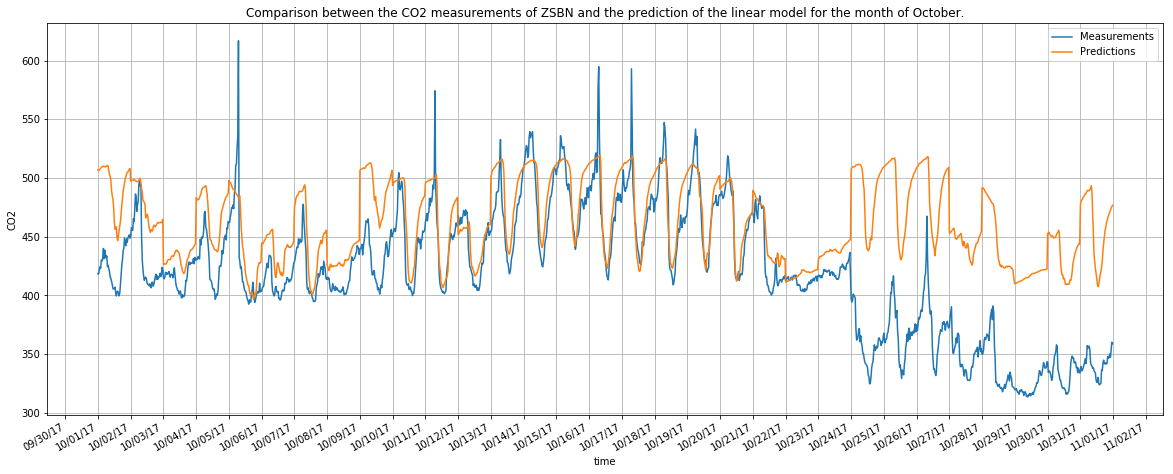

In [64]:
ax = To_plot[To_plot.LocationName == 'ZSBN'][['CO2','Prediction']].plot(figsize=(20,8))


ax.set_title("Comparison between the CO2 measurements of ZSBN and the prediction of the linear model for the month of October.")
ax.set_ylabel("CO2")
ax.legend(['Measurements', 'Predictions'])
ax.xaxis.set_major_locator( mdates.DayLocator() )
ax.xaxis.set_major_formatter(mdates.DateFormatter('%D'))
ax.grid()

plt.show()

Yes, we can clearly see the problem with this plot, starting from 24th of October (even thow the ticks dont show this date), we can see the difference between the prediction and the mesurement for this particular sensor grows with time after that date. They are no longuer superposable.

### Question III.c. (2/15)

Focus on the `KBRL` site. Apply the same procedure by fitting a linear model to the days with similar wind behavior. Plot and compare the actual CO2 measurements, and the values obtained by the linear model for the entire month of October. If all the steps are done correcly, you should be able detect the outlier observed in the beginning of October. 

In [65]:
zone = float( alt_clusters[alt_clusters.LocationName == 'KBRL'].zone )
cluster = int( alt_clusters[alt_clusters.LocationName == 'KBRL'].cluster )
print("The zone of ZSBN is %s, and the wind cluster is %s" % (zone, cluster))

The zone of ZSBN is 7.0, and the wind cluster is 2


In [66]:
alt_clusters_KBRL = alt_clusters[ alt_clusters.cluster == cluster]
alt_clusters_KBRL

,LocationName,zone,altitude,cluster
10,WMOO,4.0,526.3,2
35,ZRDH,3.0,470.0,2
4,KTGM,2.0,530.3,2
3,KBRL,7.0,510.5,2
2,BUDF,10.0,490.2,2
21,ZFHB,8.0,518.5,2
1,BSCR,2.0,462.3,2
43,ZUBG,3.0,480.7,2


In [67]:
sensors_location = alt_clusters_KBRL.LocationName.tolist()

resampled_meas = pd.read_csv("zurich_measurements.csv")
resampled_meas = resampled_meas.set_index('timestamp')
resampled_meas.index = pd.to_datetime(resampled_meas.index)

KBRL_neighbors = resampled_meas[ resampled_meas.LocationName.isin( sensors_location ) ]
KBRL_neighbors.head()

,LocationName,SensorUnit_ID,CO2,temperature,humidity
timestamp,,,,,
2017-10-01 00:00:00,ZRDH,1034,337.298130,10.290000,93.370321
2017-10-01 00:30:00,ZRDH,1034,340.127627,10.336667,94.056966
2017-10-01 01:00:00,ZRDH,1034,338.640770,10.353333,94.339254
2017-10-01 01:30:00,ZRDH,1034,342.613645,10.293333,94.431442
2017-10-01 02:00:00,ZRDH,1034,342.824630,10.246667,94.425720


In [68]:
KBRL_neighbors['date'] = pd.to_datetime( KBRL_neighbors.index.date )
KBRL_neighbors['period'] = ( ( KBRL_neighbors.index.hour*60+KBRL_neighbors.index.minute+KBRL_neighbors.index.second/60 ) / 30 )
KBRL_neighbors['period'] = KBRL_neighbors['period'].astype(int)

print( "Periods spread from %s to %s " % ( ZSBN_neighbors.period.min(), ZSBN_neighbors.period.max()) )

Periods spread from 0 to 47 


In [69]:
KBRL_neighbors['time']=KBRL_neighbors.index
KBRL_neighbors = pd.merge( KBRL_neighbors, temp_clusters, how='outer', on='date') 
KBRL_neighbors.head()

,LocationName,SensorUnit_ID,CO2,temperature,humidity,date,period,time,0,1,cluster,wind_speed
0,ZRDH,1034,337.298130,10.290000,93.370321,2017-10-01,0,2017-10-01 00:00:00,-4.106523,-1.66355,1,0.923542
1,ZRDH,1034,340.127627,10.336667,94.056966,2017-10-01,1,2017-10-01 00:30:00,-4.106523,-1.66355,1,0.923542
2,ZRDH,1034,338.640770,10.353333,94.339254,2017-10-01,2,2017-10-01 01:00:00,-4.106523,-1.66355,1,0.923542
3,ZRDH,1034,342.613645,10.293333,94.431442,2017-10-01,3,2017-10-01 01:30:00,-4.106523,-1.66355,1,0.923542
4,ZRDH,1034,342.824630,10.246667,94.425720,2017-10-01,4,2017-10-01 02:00:00,-4.106523,-1.66355,1,0.923542


In [70]:
KBRL_neighbors = KBRL_neighbors.drop([0,1], axis=1)
KBRL_neighbors.isnull().any()

LocationName     False
SensorUnit_ID    False
CO2              False
temperature      False
humidity         False
date             False
period           False
time             False
cluster          False
wind_speed       False
dtype: bool

In [71]:
KBRL_neighbors_by_cluster = {}

for i in range(0,6):
    KBRL_neighbors_by_cluster[i] = KBRL_neighbors[ KBRL_neighbors.cluster == i ]

In [72]:
lm0 = linear_model_2(KBRL_neighbors_by_cluster[0])
lm1 = linear_model_2(KBRL_neighbors_by_cluster[1])
lm2 = linear_model_2(KBRL_neighbors_by_cluster[2])
lm3 = linear_model_2(KBRL_neighbors_by_cluster[3])
lm4 = linear_model_2(KBRL_neighbors_by_cluster[4])
lm5 = linear_model_2(KBRL_neighbors_by_cluster[5])

In [73]:
resampled_meas['period'] = ( ( resampled_meas.index.hour*60+resampled_meas.index.minute+resampled_meas.index.second/60 ) / 30 )
resampled_meas['period'] = resampled_meas['period'].astype(int)

In [74]:
predictions_KBRL_0 = lm0.predict(KBRL_neighbors_by_cluster[0][["temperature","humidity","period"]])
KBRL_neighbors_by_cluster[0]['Prediction'] = predictions_KBRL_0

predictions_KBRL_1 = lm1.predict(KBRL_neighbors_by_cluster[1][["temperature","humidity","period"]])
KBRL_neighbors_by_cluster[1]['Prediction'] = predictions_KBRL_1

predictions_KBRL_2 = lm2.predict(KBRL_neighbors_by_cluster[2][["temperature","humidity","period"]])
KBRL_neighbors_by_cluster[2]['Prediction'] = predictions_KBRL_2

predictions_KBRL_3 = lm3.predict(KBRL_neighbors_by_cluster[3][["temperature","humidity","period"]])
KBRL_neighbors_by_cluster[3]['Prediction'] = predictions_KBRL_3

predictions_KBRL_4 = lm4.predict(KBRL_neighbors_by_cluster[4][["temperature","humidity","period"]])
KBRL_neighbors_by_cluster[4]['Prediction'] = predictions_KBRL_4

predictions_KBRL_5 = lm5.predict(KBRL_neighbors_by_cluster[5][["temperature","humidity","period"]])
KBRL_neighbors_by_cluster[5]['Prediction'] = predictions_KBRL_5

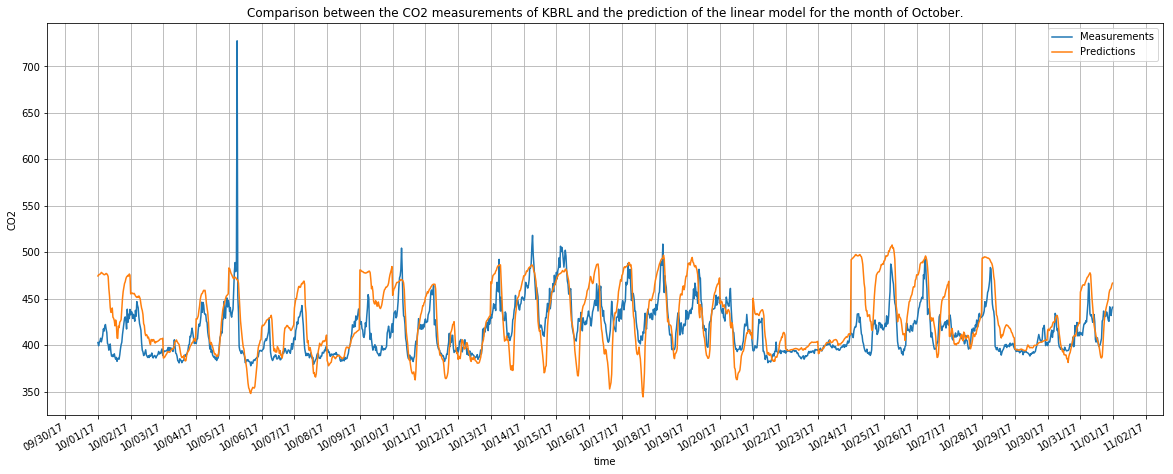

In [75]:
To_plot2 = pd.concat(KBRL_neighbors_by_cluster)
To_plot2 = To_plot2.set_index('time')
ax = To_plot2[To_plot2.LocationName == 'KBRL'][['CO2','Prediction']].plot(figsize=(20,8))


ax.set_title("Comparison between the CO2 measurements of KBRL and the prediction of the linear model for the month of October.")
ax.set_ylabel("CO2")
ax.legend(['Measurements', 'Predictions'])
ax.xaxis.set_major_locator( mdates.DayLocator() )
ax.xaxis.set_major_formatter(mdates.DateFormatter('%D'))
ax.grid()

plt.show()

We can clearly see the outlier on the 5th of October corresponding to a CO2 measure higher than 700

## PART IV: Share your work with the domain expert (10 points)

The domain experts would like to try out your work but they have python 2.6 installed and they
do not want to install anaconda3.
They tried to create a `Dockerfile` in order to build a Docker image and play with the notebook
but it didn't work.

Use
```bash
docker build -t co2notebook .
```
and
```bash
docker run --init --rm -it -p 8888:8888 co2notebook
```
to play with the Docker image.
More details can be found in the README file.

Notice how the notebook opens but that the first code cell cannot be executed.
```
---------------------------------------------------------------------------
ModuleNotFoundError                       Traceback (most recent call last)
[...]
```

### Question IV.a. (10/10)

Edit the `Dockerfile` so that you can execute the whole notebook from the `docker run` command.
This means that all the cells should run, not just the first one.

While this task can be completed by minor modifications, you are free to edit any part of the `Dockerfile`.

For a complete read over how a `Dockerfile` works, head to https://docs.docker.com/engine/reference/builder/.